## IMPORTS

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, class_weight
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Other
import os
import shutil
import cv2  # For image processing
import random
from google.colab import userdata









In [2]:
# Access the secret key
secret_value = userdata.get('shisiajoy')

In [3]:
pip install pillow


In [4]:
# Install Kaggle API if not already installed
!pip install kaggle


In [5]:
!kaggle datasets download -d gauravduttakiit/rsna-screening-mammography-breast-cancer-detection



Dataset URL: https://www.kaggle.com/datasets/gauravduttakiit/rsna-screening-mammography-breast-cancer-detection
License(s): CC0-1.0
100% 0.98G/0.98G [00:13<00:00, 98.8MB/s]
100% 0.98G/0.98G [00:13<00:00, 80.2MB/s]


In [6]:
!unzip rsna-screening-mammography-breast-cancer-detection.zip -d /content/rsna_mammography_dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/rsna_mammography_dataset/output/train/63617_1917877119.png  
  inflating: /content/rsna_mammography_dataset/output/train/63617_887426674.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_1186739164.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_1657034655.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_335778602.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_625719002.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_1154699412.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_549972940.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_599167493.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_939566995.png  
  inflating: /content/rsna_mammography_dataset/output/train/63627_1214214469.png  
  inflating: /content/rsna_mammography_dat

In [7]:
!ls /content/rsna_mammography_dataset


output	test.csv  train.csv


In [8]:
train_df = pd.read_csv("/content/rsna_mammography_dataset/train.csv")
test_df = pd.read_csv("/content/rsna_mammography_dataset/test.csv")

In [9]:
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,cancer
0,2,10006,462822612,L,CC,61.0,0,29,10006_L,0
1,2,10006,1459541791,L,MLO,61.0,0,29,10006_L,0
2,2,10006,1864590858,R,MLO,61.0,0,29,10006_R,0
3,2,10006,1874946579,R,CC,61.0,0,29,10006_R,0
4,2,10011,220375232,L,CC,55.0,0,21,10011_L,0


In [10]:
test_df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


##EDA

- Age distribution

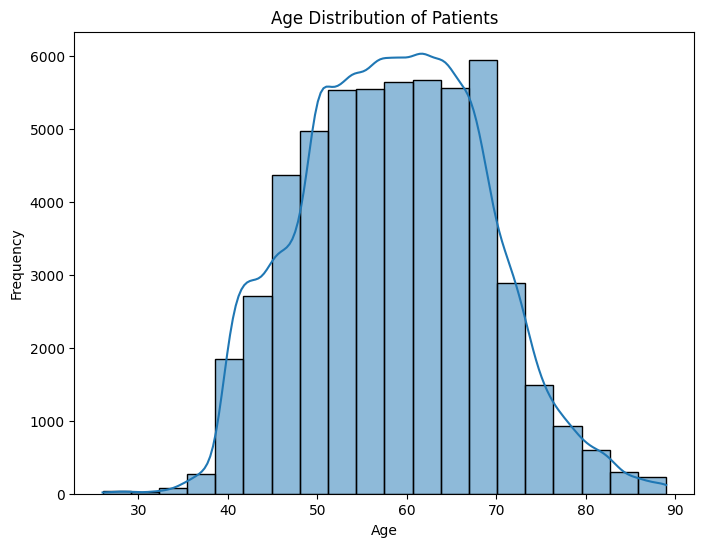

In [11]:
plt.figure(figsize=(8, 6))
sns.histplot(train_df['age'], bins=20, kde=True)
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


- Age vs Cancer

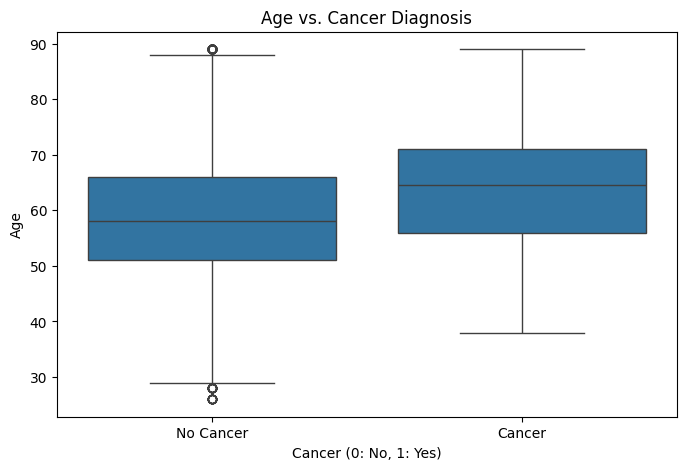

In [12]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='cancer', y='age', data=train_df)
plt.title('Age vs. Cancer Diagnosis')
plt.xlabel('Cancer (0: No, 1: Yes)')
plt.ylabel('Age')
plt.xticks([0, 1], ['No Cancer', 'Cancer'])
plt.show()


- Cancer diagnosis by Laterality and view

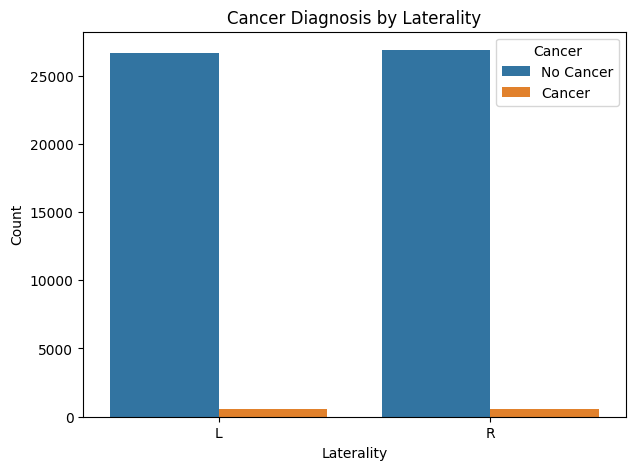

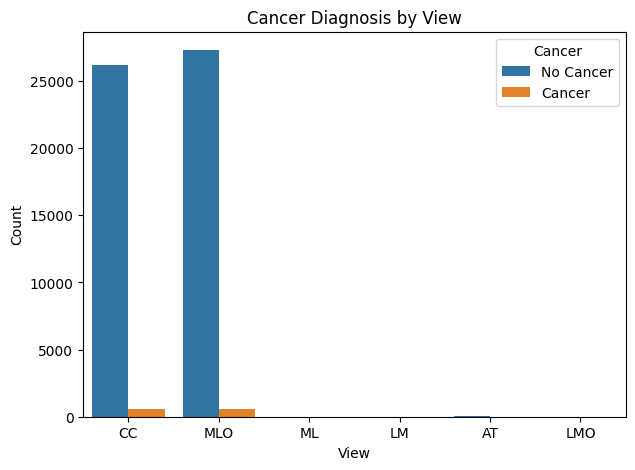

In [13]:
plt.figure(figsize=(7, 5))
sns.countplot(data=train_df, x='laterality', hue='cancer')
plt.title('Cancer Diagnosis by Laterality')
plt.xlabel('Laterality')
plt.ylabel('Count')
plt.legend(title='Cancer', labels=['No Cancer', 'Cancer'])
plt.show()

plt.figure(figsize=(7, 5))
sns.countplot(data=train_df, x='view', hue='cancer')
plt.title('Cancer Diagnosis by View')
plt.xlabel('View')
plt.ylabel('Count')
plt.legend(title='Cancer', labels=['No Cancer', 'Cancer'])
plt.show()


- Cancer class distribution

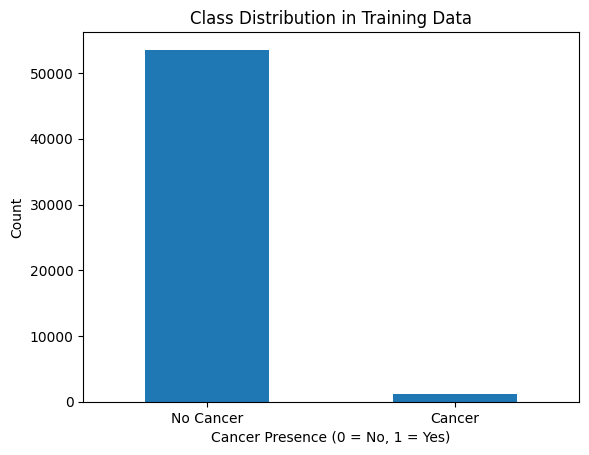

In [14]:
# Plot class distribution
train_df['cancer'].value_counts().plot(kind='bar')
plt.title('Class Distribution in Training Data')
plt.xlabel('Cancer Presence (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No Cancer', 'Cancer'], rotation=0)
plt.show()

## SETTING UP DIRECTORIES

In [15]:
# Define paths
base_path = '/content/rsna_mammography_dataset/output/train'
cancer_path = os.path.join(base_path, 'cancer')
no_cancer_path = os.path.join(base_path, 'no_cancer')


In [16]:
# Base directory paths

base_path = '/content/rsna_mammography_dataset/output/train'
cancer_path = os.path.join(base_path, 'cancer')
no_cancer_path = os.path.join(base_path, 'no_cancer')

In [17]:
# Function to add path directory to the DataFrame
def add_path_directory(row):
    patient_id = row['patient_id']
    image_id = row['image_id']
    cancer_label = row['cancer']  # 1 = cancer, 0 = no cancer

    # Construct image filename
    image_filename = f"{patient_id}_{image_id}.png"

    # Add appropriate directory path
    if cancer_label == 1:
        return os.path.join(cancer_path, image_filename)
    else:
        return os.path.join(no_cancer_path, image_filename)

# Add 'path_directory' column
train_df['path_directory'] = train_df.apply(add_path_directory, axis=1)
print("Added 'path_directory' column to train_df.")

Added 'path_directory' column to train_df.


In [18]:
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,cancer,path_directory
0,2,10006,462822612,L,CC,61.0,0,29,10006_L,0,/content/rsna_mammography_dataset/output/train...
1,2,10006,1459541791,L,MLO,61.0,0,29,10006_L,0,/content/rsna_mammography_dataset/output/train...
2,2,10006,1864590858,R,MLO,61.0,0,29,10006_R,0,/content/rsna_mammography_dataset/output/train...
3,2,10006,1874946579,R,CC,61.0,0,29,10006_R,0,/content/rsna_mammography_dataset/output/train...
4,2,10011,220375232,L,CC,55.0,0,21,10011_L,0,/content/rsna_mammography_dataset/output/train...


Move images to directory

In [19]:
# Create the cancer and no_cancer directories
os.makedirs(cancer_path, exist_ok=True)
os.makedirs(no_cancer_path, exist_ok=True)

# Function to move images to respective directories
def organize_images(row):
    patient_id = row['patient_id']
    image_id = row['image_id']
    cancer_label = row['cancer']  # Assuming 1 indicates cancer, 0 indicates no cancer

    image_filename = f"{patient_id}_{image_id}.png"
    image_path = os.path.join(base_path, image_filename)

    # Check if the image exists
    if os.path.exists(image_path):
        if cancer_label == 1:
            shutil.move(image_path, os.path.join(cancer_path, image_filename))
        else:
            shutil.move(image_path, os.path.join(no_cancer_path, image_filename))
    else:
        print(f"Image {image_filename} not found in {base_path}.")

# Apply the function to organize images
train_df.apply(organize_images, axis=1)
print("Images have been organized into 'cancer' and 'no_cancer' folders.")


Images have been organized into 'cancer' and 'no_cancer' folders.


In [20]:
# List all files in the source directory
actual_files = os.listdir('/content/rsna_mammography_dataset/output/train/no_cancer')
print(f"Number of files in 'no_cancer' directory: {len(actual_files)}")


Number of files in 'no_cancer' directory: 53548


In [21]:
# Check for mismatched extensions
expected_extensions = {'.png', '.jpg', '.jpeg'}
train_df['file_extension'] = train_df['path_directory'].apply(lambda x: os.path.splitext(x)[-1])
invalid_extensions = train_df[~train_df['file_extension'].isin(expected_extensions)]
print(f"Number of invalid extensions: {len(invalid_extensions)}")
print(invalid_extensions.head())


Number of invalid extensions: 0
Empty DataFrame
Columns: [site_id, patient_id, image_id, laterality, view, age, implant, machine_id, prediction_id, cancer, path_directory, file_extension]
Index: []


In [22]:
# Function to load a subset of images from the 'no_cancer' folder
def load_images_from_folder(folder, img_size=(128, 128), sample_size=None):
    images = []
    filenames = os.listdir(folder)

    # If a sample size is provided, randomly select images
    if sample_size:
        filenames = random.sample(filenames, sample_size)

    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
    return np.array(images)

# Load only a subset of no cancer images
subset_size = 30050
no_cancer_images = load_images_from_folder(no_cancer_path, sample_size=subset_size)


## META DATA PREPROCESSING

In [23]:
# Preprocess metadata
metadata = train_df[['laterality', 'view', 'age', 'implant']]

# One-hot encode categorical data
encoder = OneHotEncoder()
categorical_metadata = encoder.fit_transform(metadata[['laterality', 'view']]).toarray()

# Normalize numerical data
scaler = MinMaxScaler()
numerical_metadata = scaler.fit_transform(metadata[['age', 'implant']])

# Combine preprocessed metadata
processed_metadata = np.hstack((categorical_metadata, numerical_metadata))


## IMAGES PREPROCESSING

In [24]:
# Normalize and reshape the images
no_cancer_images = no_cancer_images.astype('float32') / 255.0
no_cancer_images = np.expand_dims(no_cancer_images, axis=-1)


## TRAIN VALIDATION SPLIT

In [25]:
#  Split into train and test sets
train_images, test_images = train_test_split(no_cancer_images, test_size=0.2, random_state=42)

#  Split the train set into training and validation sets
train_images, val_images = train_test_split(train_images, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2



## MODEL CREATION

In [26]:
# Define the autoencoder model
def build_autoencoder(input_shape):
    # Encoder
    encoder_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), padding='same')(encoder_input)
    x = layers.BatchNormalization()(x)  # Batch Normalization
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)  # Batch Normalization
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Latent space with tanh activation and Batch Normalization
    latent = layers.Conv2D(64, (3, 3), padding='same')(x)
    latent = layers.BatchNormalization()(latent)  # Batch Normalization
    latent = layers.Activation('tanh')(latent)

    # Decoder
    x = layers.Conv2D(64, (3, 3), padding='same')(latent)
    x = layers.BatchNormalization()(x)  # Batch Normalization
    x = layers.Activation('relu')(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)  # Batch Normalization
    x = layers.Activation('relu')(x)
    x = layers.UpSampling2D((2, 2))(x)

    # Final reconstruction layer with sigmoid activation for grayscale output
    decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Create the autoencoder model
    autoencoder = models.Model(encoder_input, decoder_output)
    return autoencoder

# Set input shape for the model (image size 128x128, with 1 channel for grayscale)
input_shape = (128, 128, 1)
autoencoder = build_autoencoder(input_shape)

# Compile the autoencoder with mean_squared_error loss
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Check the model summary to ensure the architecture
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 64, 64, 32)          │              

 Total params: 112,449 (439.25 KB)

 Trainable params: 111,937 (437.25 KB)

 Non-trainable params: 512 (2.00 KB)

In [27]:
# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


## MODEL TRAINING

In [28]:
# Train the autoencoder
history = autoencoder.fit(train_images, train_images,
                          epochs=50,
                          batch_size=32,
                          validation_data=(val_images, val_images),
                          callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 0.0086 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 2/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - loss: 0.0017 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 3/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 0.0018 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 4/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - loss: 0.0013 - val_loss: 9.4862e-04 - learning_rate: 0.0010
Epoch 5/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - loss: 0.0012 - val_loss: 9.8475e-04 - learning_rate: 0.0010
Epoch 6/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - loss: 0.0011 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 7/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.0011 - val_loss: 8.6731e-04 - learning_rate: 0.0010
Epoch 8/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - loss: 8.4470e-04 - val_loss: 7.5675e-04 - learning_rate: 5.0000e-04
Epoch 9/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 9.9347e-04 - val_l

## MODEL EVALUATION

- Visualization of reconstructed images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step


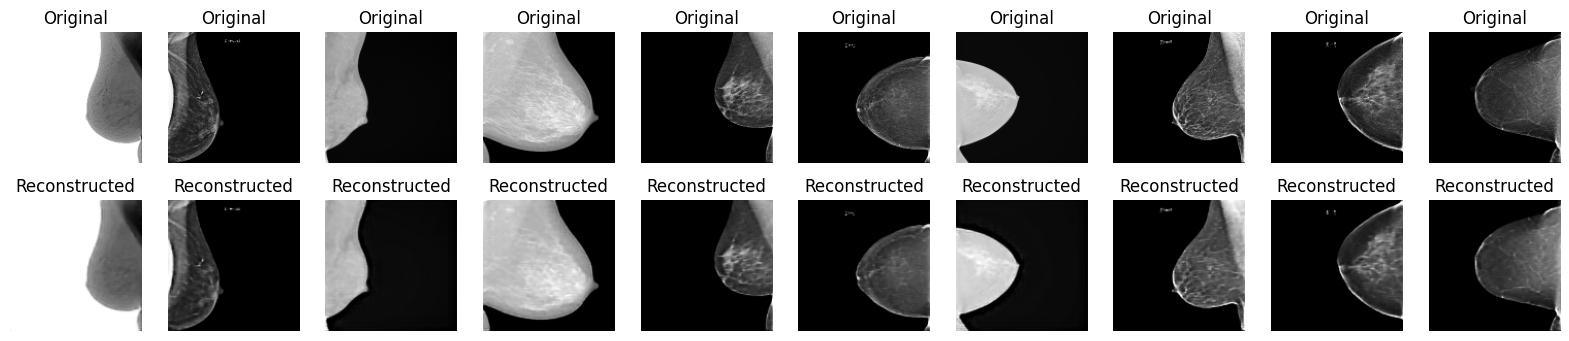

In [29]:
# Get a batch of validation images
val_images_batch = val_images[:10]
reconstructed_images = autoencoder.predict(val_images_batch)

# Plot original and reconstructed images
plt.figure(figsize=(20, 4))
for i in range(10):
    # Original images
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(val_images_batch[i].reshape(128, 128), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Reconstructed images
    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed_images[i].reshape(128, 128), cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()


## EVALUATION ON TEST SET

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


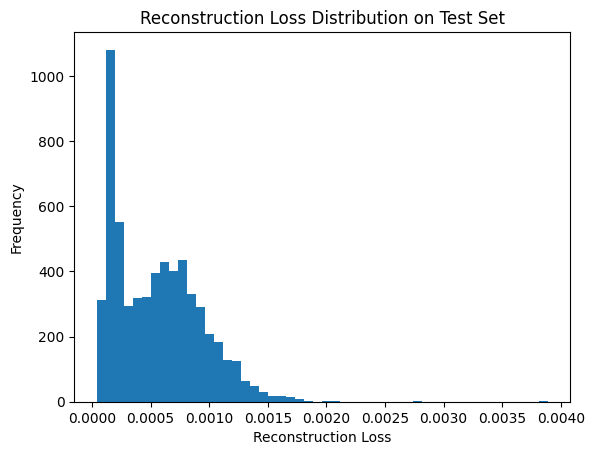

In [30]:
# Evaluate on the test set
test_images_reconstructed = autoencoder.predict(test_images)

# Calculate the reconstruction loss (mean squared error) for each image
reconstruction_loss = np.mean(np.power(test_images - test_images_reconstructed, 2), axis=(1, 2))

# Analyze reconstruction loss distribution
plt.hist(reconstruction_loss, bins=50)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Reconstruction Loss Distribution on Test Set')
plt.show()


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


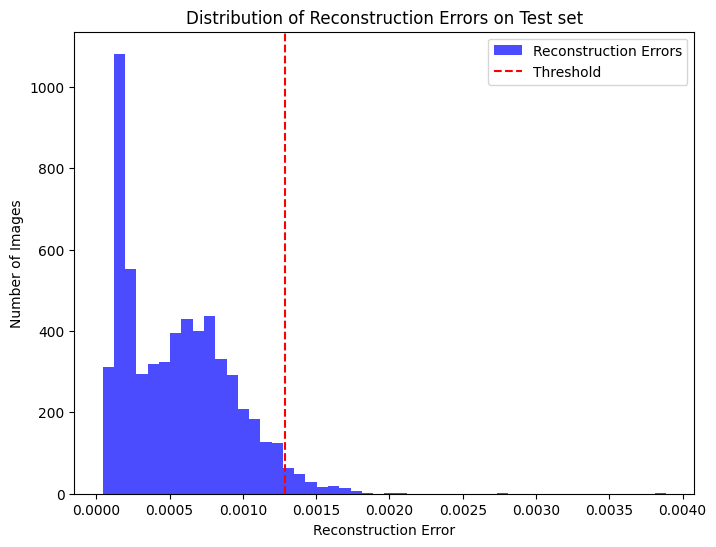

In [35]:
# Calculate Reconstruction Errors
reconstructed_images = autoencoder.predict(test_images)  # Test dataset
reconstruction_errors = np.mean((test_images - reconstructed_images) ** 2, axis=(1, 2))  # Mean Squared Error per image

# Visualize Reconstruction Errors
plt.figure(figsize=(8, 6))
plt.hist(reconstruction_errors, bins=50, color='blue', alpha=0.7, label='Reconstruction Errors')
plt.axvline(x=np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors), color='red', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Images')
plt.title('Distribution of Reconstruction Errors on Test set')
plt.legend()
plt.show()


In [34]:
# Set a Threshold
threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)

# Classify Images
anomalies = reconstruction_errors > threshold

# Count Anomalies
print(f"Number of Anomalies Detected: {np.sum(anomalies)}")


Number of Anomalies Detected: 192


In [ ]:
def compute_reconstruction_error(autoencoder, images):
    reconstructions = autoencoder.predict(images)
    errors = np.mean((images - reconstructions) ** 2, axis=(1, 2, 3))
    return errors

# Load cancer images for testing
cancer_images = load_images_from_folder(cancer_path, img_size=(128, 128))
cancer_images = cancer_images / 255.0  # Normalize
cancer_images = cancer_images.reshape(-1, 128, 128, 1)

# Compute reconstruction errors
no_cancer_errors = compute_reconstruction_error(autoencoder, no_cancer_images)
cancer_errors = compute_reconstruction_error(autoencoder, cancer_images)


940/940 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


In [ ]:
# Reconstruct the test images
reconstructed_images = autoencoder.predict(test_images)

# Calculate the reconstruction loss
reconstruction_losses = np.mean(np.square(test_images - reconstructed_images), axis=(1, 2))  # Mean squared error across the image dimensions

# proceed to calculate mean and std
mean_loss = np.mean(reconstruction_losses)
std_loss = np.std(reconstruction_losses)

# Set threshold
threshold = mean_loss + 0.1 * std_loss

print(f'Mean Loss: {mean_loss:.6f}, Standard Deviation: {std_loss:.6f}, Threshold: {threshold:.6f}')


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Mean Loss: 0.000683, Standard Deviation: 0.000433, Threshold: 0.000727


## TEST ON LABLED DATA

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Reconstruction Loss: 0.000811
Anomalous: True


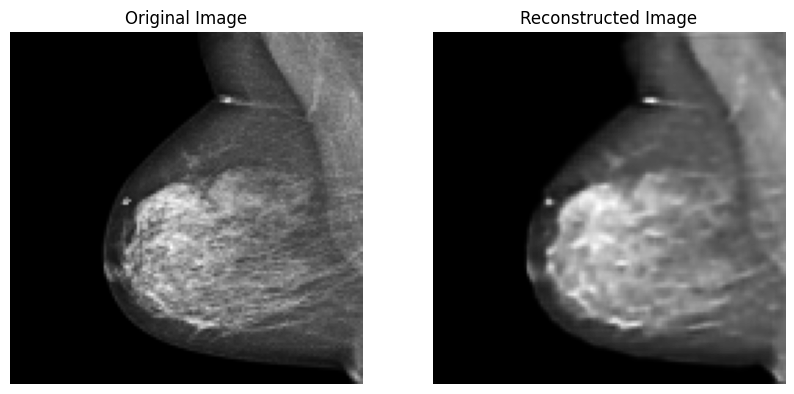

In [ ]:
# Load and preprocess the single cancer image
image_path = '/content/rsna_mammography_dataset/output/test/10008_68070693.png'  # Path to your image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
image = cv2.resize(image, (128, 128))  # Resize to match input shape
image = image.astype('float32') / 255.0  # Normalize to [0, 1]
image = np.expand_dims(image, axis=-1)  # Add channel dimension
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Reconstruct the image using the autoencoder
reconstructed_image = autoencoder.predict(image)

# Calculate the reconstruction loss
reconstruction_loss = np.mean(np.square(image - reconstructed_image))

# Classify based on the threshold
is_anomalous = reconstruction_loss > threshold

# Output results
print(f'Reconstruction Loss: {reconstruction_loss:.6f}')
print(f'Anomalous: {is_anomalous}')

# visualize the original and reconstructed images

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image.squeeze(), cmap='gray')
plt.axis('off')

plt.show()


## SAVE MODEL AND THRESHOLD

In [32]:
 # Save the autoencoder in Keras format
autoencoder.save('autoencoder_model.keras')

In [33]:
from google.colab import files
files.download('autoencoder_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json

# Save the threshold value to a JSON file
threshold_value = 0.000727
with open('threshold.json', 'w') as json_file:
    json.dump({'threshold': threshold_value}, json_file)